In [148]:
import torch.nn as nn
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error,mean_absolute_error
from torch.utils.data import Dataset, DataLoader,Subset
from torchvision.transforms import Compose,Lambda,ToTensor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut, KFold
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 
import random
os.environ['CUDA_VISIBLE_DEVICES']="3"


In [174]:
# Worj with 64 bits in torch
torch.set_default_tensor_type(torch.DoubleTensor)

In [175]:
def seed_everything(seed=10):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [176]:
dataset = np.load('Final_dataset_51.npy',allow_pickle=True)
X = pd.DataFrame(dataset[:,1:-2], dtype=np.float64)
y = pd.DataFrame(dataset[:,-1], dtype=np.float64)


In [177]:
X = torch.tensor(X.values, dtype=torch.float64)
Y = torch.tensor(y.values, dtype=torch.float64)

In [178]:
X.shape, y.shape

(torch.Size([51, 307]), (51, 1))

In [179]:
pd.DataFrame(X).describe()

,0,1,2,3,4,5,6,7,8,9,...,297,298,299,300,301,302,303,304,305,306
count,5.100000e+01,5.100000e+01,5.100000e+01,5.100000e+01,5.100000e+01,5.100000e+01,5.100000e+01,5.100000e+01,5.100000e+01,5.100000e+01,...,5.100000e+01,5.100000e+01,5.100000e+01,5.100000e+01,51.000000,51.000000,51.000000,51.000000,51.000000,5.100000e+01
mean,1.070769e-05,1.071618e-05,1.073616e-05,1.076904e-05,1.081603e-05,1.088863e-05,1.100820e-05,1.121553e-05,1.159973e-05,1.225167e-05,...,7.793171e-07,8.644869e-06,9.548220e-05,1.718276e-03,0.039538,0.143909,0.103729,0.063526,0.006799,3.336587e-06
std,2.222451e-05,2.222905e-05,2.224373e-05,2.226501e-05,2.229396e-05,2.232711e-05,2.237044e-05,2.238985e-05,2.243879e-05,2.252010e-05,...,1.254102e-06,1.499292e-05,1.514088e-04,2.966517e-03,0.067162,0.251976,0.192649,0.131487,0.014837,7.498785e-06
min,3.556749e-07,3.555027e-07,3.592872e-07,3.609818e-07,4.040686e-07,4.183824e-07,4.328141e-07,4.765701e-07,5.323838e-07,6.699618e-07,...,5.072023e-10,5.038865e-09,5.875387e-08,8.995459e-07,0.000012,0.000034,0.000017,0.000009,0.000001,3.117331e-10
25%,1.067454e-06,1.067825e-06,1.068818e-06,1.078658e-06,1.079243e-06,1.167496e-06,1.218321e-06,1.382765e-06,2.132413e-06,2.249076e-06,...,2.511822e-08,2.251575e-07,2.670637e-06,4.674878e-05,0.001304,0.002544,0.000685,0.000323,0.000031,1.044539e-08
50%,3.516737e-06,3.519233e-06,3.524362e-06,3.531463e-06,3.541209e-06,3.578248e-06,3.648565e-06,3.722174e-06,4.382213e-06,5.774228e-06,...,1.116434e-07,1.237850e-06,1.849383e-05,4.634532e-04,0.010682,0.018821,0.006467,0.003926,0.000442,8.556726e-08
75%,9.667675e-06,9.687521e-06,9.719614e-06,9.788472e-06,9.867477e-06,9.977690e-06,1.004496e-05,1.009440e-05,1.031907e-05,1.220452e-05,...,6.965439e-07,9.963603e-06,1.112578e-04,1.154455e-03,0.030619,0.093256,0.059803,0.036533,0.003484,1.469251e-06
max,1.363066e-04,1.363377e-04,1.364201e-04,1.365600e-04,1.367396e-04,1.369708e-04,1.373023e-04,1.376454e-04,1.382303e-04,1.392155e-04,...,4.453005e-06,6.404671e-05,5.528444e-04,1.201147e-02,0.293747,1.105272,0.741801,0.585203,0.065643,3.396095e-05


In [180]:
# Normalize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

pd.DataFrame(X).describe()
X = torch.tensor(X, dtype=torch.float64)
X = X.to('cuda')

In [181]:
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, output_dim)
        self.gelu = nn.GELU()
        
    def forward(self, x):
        x = self.fc1(x)
        x = torch.sin(x)
        x = self.fc2(x)
        x = torch.sin(x)
        x = self.fc3(x)
        x = torch.sin(x)
        x = self.fc4(x)
        x = torch.exp(x)
        return x

In [182]:
criterion = nn.MSELoss()


def train(model, train_X, train_Y, optimizer, criterion, n_epochs):
    
    model.train()
    losses = []
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        outputs = model(train_X)
        loss = criterion(outputs, train_Y)
        loss.backward()
        optimizer.step()
        lossi = loss.item()
        #print(epoch, lossi)
        losses.append(lossi)
    return losses


In [183]:
def predict(model, test_X):
    model.eval()
    with torch.no_grad():
        predictions = model(test_X)
    return predictions

In [184]:
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.2, random_state=10)

train_X.shape, test_X.shape, train_Y.shape, test_Y.shape
train_X = train_X.to('cuda')
train_Y = train_Y.to('cuda')
test_X = test_X.to('cuda')
test_Y = test_Y.to('cuda')


In [185]:
train_X, train_Y

(tensor([[-0.2830, -0.2815, -0.2823,  ...,  0.0641, -0.1482, -0.1358],
         [-0.4550, -0.4553, -0.4558,  ..., -0.4872, -0.4617, -0.4487],
         [ 0.0593,  0.0596,  0.0610,  ...,  1.5935,  1.2370,  1.3846],
         ...,
         [-0.2285, -0.2286, -0.2288,  ..., -0.4445, -0.4255, -0.4458],
         [-0.4565, -0.4568, -0.4573,  ..., -0.4854, -0.4606, -0.4489],
         [-0.2386, -0.2374, -0.2375,  ...,  1.3642,  1.2747,  1.1939]],
        device='cuda:0'),
 tensor([[3.2100],
         [3.4200],
         [3.1000],
         [3.4200],
         [2.9100],
         [3.1200],
         [3.1100],
         [2.9100],
         [3.1600],
         [2.8900],
         [3.6000],
         [3.1600],
         [3.3000],
         [3.3000],
         [3.1100],
         [3.4900],
         [3.2000],
         [3.1000],
         [4.2400],
         [3.1600],
         [2.9600],
         [3.0200],
         [3.3000],
         [2.7200],
         [3.3900],
         [3.0600],
         [3.4500],
         [3.2800],
 

In [186]:
model = SimpleMLP(train_X.shape[1], train_Y.shape[1]).to('cuda')
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
losses = train(model, train_X, train_Y, optimizer, criterion, n_epochs=1000)

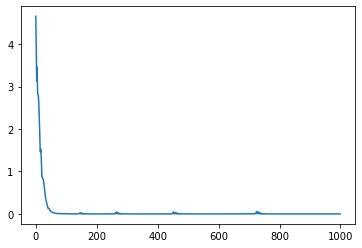

In [187]:
plt.plot(losses)

In [188]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error,mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

In [189]:
loo = LeaveOneOut()
mses ={"NN": [], "RF": []}
maes = {"NN": [], "RF": []}
mapes = {"NN": [], "RF": []}
preds  = {"NN": [], "RF": []}
gts = [] 
for train_index, test_index in loo.split(X[:5]):
    print("TRAIN:", train_index, "TEST:", test_index)
    train_X, test_X = X[train_index], X[test_index]
    train_Y, test_Y = Y[train_index], Y[test_index]
    rf = RandomForestRegressor(n_estimators=100, random_state=10)
    rf.fit(train_X.cpu().numpy(), train_Y.cpu().numpy())
    pred_rf = rf.predict(test_X.cpu().numpy())
    gts.append(test_Y.cpu().detach().numpy().flatten()[0])
    preds["RF"].append(pred_rf.flatten()[0])
    train_X = train_X.to('cuda')
    train_Y = train_Y.to('cuda')
    test_X = test_X.to('cuda')
    test_Y = test_Y.to('cuda')
    model = SimpleMLP(train_X.shape[1], train_Y.shape[1]).to('cuda')
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    losses = train(model, train_X, train_Y, optimizer, criterion, n_epochs=1000)
    
    predictions = predict(model, test_X)
    preds["NN"].append(predictions.cpu().detach().numpy().flatten()[0])
    nn_mse_i = mean_squared_error(test_Y.cpu().detach().numpy(), predictions.cpu().detach().numpy())
    nn_mae_i = mean_absolute_error(test_Y.cpu().detach().numpy(), predictions.cpu().detach().numpy())
    nn_mape_i = mean_absolute_percentage_error(test_Y.cpu().detach().numpy(), predictions.cpu().detach().numpy())

    rf_mse_i = mean_squared_error(test_Y.cpu().detach().numpy(), pred_rf)
    rf_mae_i = mean_absolute_error(test_Y.cpu().detach().numpy(), pred_rf)
    rf_mape_i = mean_absolute_percentage_error(test_Y.cpu().detach().numpy(), pred_rf)
    mses["NN"].append(nn_mse_i)
    maes["NN"].append(nn_mae_i)
    mapes["NN"].append(nn_mape_i)
    mses["RF"].append(rf_mse_i)
    maes["RF"].append(rf_mae_i)
    mapes["RF"].append(rf_mape_i)
    # Print the results for current iteration in one line
    print("NN MSE: {:.2f}, RF MSE: {:.2f}, NN MAE: {:.2f}, RF MAE: {:.2f}, NN MAPE: {:.2f}, RF MAPE: {:.2f}".format(nn_mse_i, rf_mse_i, nn_mae_i, rf_mae_i, nn_mape_i, rf_mape_i))
    print("-----------------------------------------")

TRAIN: [1 2 3 4] TEST: [0]


/tmp/ipykernel_3783431/3273878974.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(train_X.cpu().numpy(), train_Y.cpu().numpy())


NN MSE: 6.91, RF MSE: 0.09, NN MAE: 2.63, RF MAE: 0.30, NN MAPE: 0.88, RF MAPE: 0.10
-----------------------------------------
TRAIN: [0 2 3 4] TEST: [1]


/tmp/ipykernel_3783431/3273878974.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(train_X.cpu().numpy(), train_Y.cpu().numpy())


NN MSE: 0.91, RF MSE: 0.38, NN MAE: 0.96, RF MAE: 0.61, NN MAPE: 0.27, RF MAPE: 0.17
-----------------------------------------
TRAIN: [0 1 3 4] TEST: [2]


/tmp/ipykernel_3783431/3273878974.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(train_X.cpu().numpy(), train_Y.cpu().numpy())


NN MSE: 0.06, RF MSE: 0.00, NN MAE: 0.24, RF MAE: 0.05, NN MAPE: 0.08, RF MAPE: 0.02
-----------------------------------------
TRAIN: [0 1 2 4] TEST: [3]


/tmp/ipykernel_3783431/3273878974.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(train_X.cpu().numpy(), train_Y.cpu().numpy())


NN MSE: 0.28, RF MSE: 0.04, NN MAE: 0.53, RF MAE: 0.20, NN MAPE: 0.18, RF MAPE: 0.07
-----------------------------------------
TRAIN: [0 1 2 3] TEST: [4]


/tmp/ipykernel_3783431/3273878974.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(train_X.cpu().numpy(), train_Y.cpu().numpy())


NN MSE: 3.19, RF MSE: 0.06, NN MAE: 1.79, RF MAE: 0.24, NN MAPE: 0.62, RF MAPE: 0.08
-----------------------------------------


In [190]:
pd.DataFrame(mses)

,NN,RF
0,6.906291,0.090060
1,0.912278,0.377242
2,0.055769,0.002884
3,0.283887,0.038377
4,3.187432,0.058709


In [132]:
pd.DataFrame(mses)

,NN,RF
0,6.964166,7.935486e-02
1,0.871902,3.798256e-01
2,0.031845,8.102388e-07
3,0.189651,2.676493e-02
4,2.418280,9.947708e-02


In [191]:
(pd.DataFrame(mapes)*100)

,NN,RF
0,87.599412,10.003333
1,26.531463,17.061111
2,7.617901,1.732258
3,18.436356,6.778547
4,61.776406,8.384083


In [133]:
(pd.DataFrame(mapes)*100)

,NN,RF
0,87.965683,9.389998
1,25.937691,17.119442
2,5.756532,0.029037
3,15.068854,5.660896
4,53.809063,10.913490


In [192]:
d = pd.DataFrame(preds)
d

,NN,RF
0,0.372018,3.3001
1,2.644867,2.9858
2,2.863845,3.0463
3,3.422811,3.0859
4,1.104662,3.1323


In [193]:
d["gt"] = gts
d

,NN,RF,gt
0,0.372018,3.3001,3.00
1,2.644867,2.9858,3.60
2,2.863845,3.0463,3.10
3,3.422811,3.0859,2.89
4,1.104662,3.1323,2.89
